In [1]:
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#use_gpu = torch.cuda.is_available()

# Function area
Parameters summary function come from stackoverflow：  <br/>
https://stackoverflow.com/questions/42480111/model-summary-in-pytorch

'''
Note1.<br/>
def _addindent(s_, numSpaces):
    s = s_.split('\n')
    # dont do anything for single-line stuff
    if len(s) == 1:
        return s_
    first = s.pop(0)
    s = [(numSpaces * ' ') + line for line in s]
    s = '\n'.join(s)
    s = first + '\n' + s
    return s

Note2. np.prod: Return the product of array elements over a given axis.
'''

In [3]:
# Function 1
from torch.nn.modules.module import _addindent
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    total_params = 0
    tmpstr = model.__class__.__name__ + ' :\n' #Pring the object name
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
                    torch.nn.modules.container.Container,
                    torch.nn.modules.container.Sequential
                            ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2) # Note1
        
        params = sum([np.prod(p.size()) for p in module.parameters()]) # Note2
        weights = tuple([tuple(p.size()) for p in module.parameters()])
        total_params = total_params + params 
        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n------------------------------------------------------\n'
    tmpstr = tmpstr + ')'
    tmpstr = tmpstr + ' \n##Total Parameters = {} '.format(total_params)
    return tmpstr


# Function 2
def show_batch(batch):
    '''Show image of one batch'''
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

# Load MNIST Data

In [4]:
BATCH_SIZE = 200 # setting batch size
transform = transforms.ToTensor() # Transform them to tensors

# Load and transform data
trainset = torchvision.datasets.MNIST('./mnist', train=True, download=True, transform=transform)
#testset = torchvision.datasets.MNIST('./mnist', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
#testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Batch shape:  torch.Size([200, 1, 28, 28])


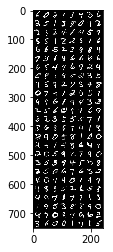

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

#print('Labels: ', list(labels))
print('Batch shape: ', images.size())
show_batch(images)

# Build Shallow Model
How to get the size of feature map: <br>
Output H = 1 + (input H + 2Panding - Filter H)/Stride <br>
Output W = 1 + (input W + 2Panding - Filter W)/Stride <br>

In [10]:
class Shallow_model(nn.Module):
    def __init__(self):
        super(Shallow_model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=105, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        
        # fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=13*13*105, out_features=10))
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return F.log_softmax(out) #last layer is softmax layer

In [11]:
# Setting the model & loss function & optimizer
SNet = Shallow_model()
loss_func = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(SNet.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [12]:
print(torch_summarize(SNet))

Shallow_model :
  (layer1): Sequential :
    (0): Conv2d(1, 105, kernel_size=(3, 3), stride=(1, 1)), weights=((105, 1, 3, 3), (105,)), parameters=1050
  ------------------------------------------------------
    (1): ReLU(inplace), weights=(), parameters=0
  ------------------------------------------------------
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False), weights=(), parameters=0
  ------------------------------------------------------
  ) 
  ##Total Parameters = 1050 , weights=((105, 1, 3, 3), (105,)), parameters=1050
------------------------------------------------------
  (fc1): Sequential :
    (0): Linear(in_features=17745, out_features=10, bias=True), weights=((10, 17745), (10,)), parameters=177460
  ------------------------------------------------------
  ) 
  ##Total Parameters = 177460 , weights=((10, 17745), (10,)), parameters=177460
------------------------------------------------------
) 
##Total Parameters = 178510 


In [13]:
# Running Model 
loss_old = 0.01
check_time = 0
num_of_epoch = 10

iters = 0
for epoch in range(num_of_epoch):
    correct = 0
    for i, (images, labels) in enumerate(trainloader):
        # convert tensor to Variable
        images = Variable(images)
        labels = Variable(labels)

        # clear gradients w.r.t parameters
        optimizer.zero_grad()

        # forward pass
        outputs = SNet(images)

        # calculate loss
        loss = loss_func(outputs, labels)

        # get gradient w.r.t parameters
        loss.backward()

        # update parameters
        optimizer.step()

        iters += 1
        
        # Accuracy (each batch)
        pred = outputs.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
        Acc = correct / ((i+1)*BATCH_SIZE) * 100
        if iters % 20 == 0:     
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f},  Accumulation batch acc={:.1f}%'.format(
                    epoch+1, i * len(images), len(trainloader.dataset),
                    100. * i / len(trainloader), loss.data[0], Acc))
    if Acc >= 97: break

/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [3800/60000 (6%)]	Loss: 124.736107,  Accumulation batch acc=60.8%
Train Epoch: 1 [7800/60000 (13%)]	Loss: 76.771278,  Accumulation batch acc=74.0%
Train Epoch: 1 [11800/60000 (20%)]	Loss: 76.151733,  Accumulation batch acc=79.6%
Train Epoch: 1 [15800/60000 (26%)]	Loss: 47.040329,  Accumulation batch acc=82.9%
Train Epoch: 1 [19800/60000 (33%)]	Loss: 44.093231,  Accumulation batch acc=85.0%
Train Epoch: 1 [23800/60000 (40%)]	Loss: 39.303097,  Accumulation batch acc=86.5%
Train Epoch: 1 [27800/60000 (46%)]	Loss: 29.995150,  Accumulation batch acc=87.7%
Train Epoch: 1 [31800/60000 (53%)]	Loss: 46.388893,  Accumulation batch acc=88.6%
Train Epoch: 1 [35800/60000 (60%)]	Loss: 27.591980,  Accumulation batch acc=89.4%
Train Epoch: 1 [39800/60000 (66%)]	Loss: 39.556881,  Accumulation batch acc=90.0%
Train Epoch: 1 [43800/60000 (73%)]	Loss: 29.579845,  Accumulation batch acc=90.5%
Train Epoch: 1 [47800/60000 (80%)]	Loss: 36.751682,  Accumulation batch acc=91.0%
Train Epoch: 1 [51

# Deep Model
How to get the size of feature map: <br>
Output H = 1 + (input H + 2Panding - Filter H)/Stride <br>
Output W = 1 + (input W + 2Panding - Filter W)/Stride <br>

In [14]:
# Filter number of Conv layers
fil = [30, 35, 30]

class Deep_model(nn.Module):
    def __init__(self):
        super(Deep_model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=fil[0], kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) )
        
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=fil[0], out_channels=fil[1], kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) )
        
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=fil[1], out_channels=fil[2], kernel_size=1, stride=1),
            nn.ReLU(inplace=True))
            #nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        # fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=5*5*fil[2], out_features=200),
            nn.ReLU(inplace=True))
    
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=200, out_features=80),
            nn.ReLU(inplace=True))
        
        

        self.fc3 = nn.Sequential(nn.Linear(in_features=80, out_features=10))
        
        
    def forward(self, x):
        out = self.layer3(self.layer2(self.layer1(x)))
        out = out.view(out.size(0), -1)
        out = self.fc3(self.fc2(self.fc1(out)))
        return F.log_softmax(out)

In [15]:
# Setting the model & loss function & optimizer
DNet = Deep_model()
loss_func = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(DNet.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [16]:
print(torch_summarize(DNet))

Deep_model :
  (layer1): Sequential :
    (0): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1)), weights=((30, 1, 5, 5), (30,)), parameters=780
  ------------------------------------------------------
    (1): ReLU(inplace), weights=(), parameters=0
  ------------------------------------------------------
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False), weights=(), parameters=0
  ------------------------------------------------------
  ) 
  ##Total Parameters = 780 , weights=((30, 1, 5, 5), (30,)), parameters=780
------------------------------------------------------
  (layer2): Sequential :
    (0): Conv2d(30, 35, kernel_size=(3, 3), stride=(1, 1)), weights=((35, 30, 3, 3), (35,)), parameters=9485
  ------------------------------------------------------
    (1): ReLU(inplace), weights=(), parameters=0
  ------------------------------------------------------
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False), 

In [17]:
iters = 0
for epoch in range(10):
    correct = 0
    for i, (images, labels) in enumerate(trainloader):
        # convert tensor to Variable
        images = Variable(images)
        labels = Variable(labels)

        # clear gradients w.r.t parameters
        optimizer.zero_grad()

        # forward pass
        outputs = DNet(images)

        # calculate loss
        loss = loss_func(outputs, labels)

        # get gradient w.r.t parameters
        loss.backward()

        # update parameters
        optimizer.step()

        iters += 1
        # Accuracy (each batch)
        pred = outputs.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
        Acc = correct / ((i+1)*BATCH_SIZE) * 100
        if iters % 20 == 0:     
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f},  Accumulation batch acc={:.1f}%'.format(
                    epoch+1, i * len(images), len(trainloader.dataset),
                    100. * i / len(trainloader), loss.data[0], Acc))
    if Acc >= 97: break     

/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [3800/60000 (6%)]	Loss: 366.770233,  Accumulation batch acc=28.1%
Train Epoch: 1 [7800/60000 (13%)]	Loss: 135.742355,  Accumulation batch acc=49.6%
Train Epoch: 1 [11800/60000 (20%)]	Loss: 93.916733,  Accumulation batch acc=61.4%
Train Epoch: 1 [15800/60000 (26%)]	Loss: 82.038795,  Accumulation batch acc=67.9%
Train Epoch: 1 [19800/60000 (33%)]	Loss: 51.646832,  Accumulation batch acc=72.2%
Train Epoch: 1 [23800/60000 (40%)]	Loss: 70.576019,  Accumulation batch acc=75.4%
Train Epoch: 1 [27800/60000 (46%)]	Loss: 29.793171,  Accumulation batch acc=77.9%
Train Epoch: 1 [31800/60000 (53%)]	Loss: 19.501791,  Accumulation batch acc=80.0%
Train Epoch: 1 [35800/60000 (60%)]	Loss: 24.378628,  Accumulation batch acc=81.7%
Train Epoch: 1 [39800/60000 (66%)]	Loss: 29.607759,  Accumulation batch acc=83.1%
Train Epoch: 1 [43800/60000 (73%)]	Loss: 31.054874,  Accumulation batch acc=84.3%
Train Epoch: 1 [47800/60000 (80%)]	Loss: 23.495838,  Accumulation batch acc=85.3%
Train Epoch: 1 [5